In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from scipy import stats

# Block Level Data 

In [4]:
blocks = pd.read_csv("blocks50.csv")

In [5]:
blocks.head(2)

,LOGRECNO,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42075,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160
0,8303,1102,389,26,9,34,0,27,0,19,...,0,81,0,38,4,21,0,0,18,0
1,8304,1061,470,33,31,43,20,31,0,15,...,0,103,0,56,23,9,0,0,15,0


In [6]:
blocks.shape

(15463, 1966)

In [7]:
attr = pd.read_csv("attr_interconn.csv")

In [8]:
attr.head(2)

,Unnamed: 0,Q_name,puma_attr,block_attr,ourID
0,0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [9]:
attr.shape

(42796, 5)

In [10]:
features = pd.read_csv("features_we_use.csv")

In [11]:
features.head(2)

,Unnamed: 0,Q_name,puma_attr,block_attr,ourID
0,0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [12]:
features.shape

(1965, 5)

In [13]:
predict = pd.read_csv("predict.csv")

In [14]:
predict.head(2)

,st,0165_10,0165_11,0165_12,0165_13,0165_14,0165_15,0165_16,0165_17,0165_18,...,0165_23,0165_24,0165_25,0165_26,0165_27,0165_28,0165_29,0165_30,internetP,label
0,il_129,284747,192327,3587,43965,13861,30104,90127,35810,54317,...,3133,6751,18757,7717,11040,23425,11487,80933,67.543117,train
1,wi_57,231386,143848,1469,29031,11311,17720,80797,38049,42748,...,562,1340,12964,5787,7177,12422,15409,72129,62.167979,train


In [15]:
predict.shape

(5777, 24)

# Reading Puma Data

In [16]:
puma = pd.read_csv("puma50.csv")

In [17]:
puma.head(2)

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,label
0,il_129,710667,351639,22906,23456,24982,14097,8870,5073,4804,...,85878,0,25100,29949,7047,74,2341,21367,768,train
1,wi_57,599168,288604,22838,22923,21190,12728,10750,7433,5315,...,39792,39,12252,8283,8970,0,1870,8378,363,train


In [18]:
puma['label'].value_counts()

train    3696
test     1156
valid     925
dtype: int64

In [19]:
pumadata=puma.copy()

# Percentages of internet Users

In [20]:
internetper = predict['0165_11']/(predict['0165_10'])

### Defining threshhold to divide data between 0 and 1 i.e. no internet connection or internet connection. percentage of internet users > median is 1 and less than median 0


In [22]:
pumadata['internet']= internetper.apply(lambda x: 1 if x>=internetper.median() else 0)

## Giving dummy value to "st" id

In [23]:
pumadata['st'] = pd.get_dummies(data=pumadata, columns=['st'], sparse=True)

### Dividing Data in Test Train and validation based on predifined labels. 
### And dropping labels

In [24]:
train = pumadata.loc[pumadata['label'] == 'train']
train = train.drop(['label'], axis=1)
test = pumadata.loc[pumadata['label'] == 'test']
test = test.drop(['label'], axis=1)

In [25]:
valid= pumadata.loc[pumadata['label'] == 'valid']
valid = valid.drop(['label'], axis=1)

Seperating Labels from each of training, testing and validation data sets so we are only left with features and labels stored in different variables.  

Converting each of the string nan values to numpy int nan values and converting all the features to numpy array

In [26]:
label_train = np.ravel(train[['internet']].values)
pred_train = train.drop(['internet'], axis=1)
pred_train = np.int64(pred_train.fillna(np.nan))

In [27]:
results = test.copy()
label_test = np.ravel(test[['internet']].values)
pred_test = test.drop(['internet'], axis=1)
feature_names = list(pred_test.columns.values)
pred_test = np.int64(pred_test.fillna(np.nan))

In [28]:
results1 = valid.copy()
label_valid = np.ravel(valid[['internet']].values)
pred_valid = valid.drop(['internet'], axis=1)
feature_names = list(pred_valid.columns.values)
pred_valid = np.int64(pred_valid.fillna(np.nan))

In [29]:
import multiprocessing
jobs=multiprocessing.cpu_count()

In [30]:
jobs

64

## Building Random Forest Classifier and training is over training data set. 
## Calculating Area Under Curve (AUC) score and accuracy 

In [31]:
num_trees = 100
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=jobs, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=pred_train, y=label_train)

# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(label_test, rf_predictions))

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print (accuracy_score(label_test, rf_predictions_class, normalize=True))

[Parallel(n_jobs=64)]: Done   1 out of 100 | elapsed:    0.2s remaining:   18.4s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.7s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 20 of 100
building tree 19 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100building tree 24 of 100building tree 25 of 100

 building tree 27 of 100building tree 28 of 100

building tree 26 of 100


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100building tree 33 of 100
 
 building tree 36 of 100building tree 37 of 100building tree 35 of 100building tree 34 of 100building tree 38 of 100building tree 39 of 100building tree 40 of 100


 

 
building tree 41 of 100
building tree 42 of 1

[Parallel(n_jobs=64)]: Done   1 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Done   1 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done   8 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  15 out of  27 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  16 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  19 out of  36 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  21 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  41 out of  80 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of


0.939446366782


### Running same model on validation set calculate AUC score

In [32]:
rf_predictions = rf.predict_proba(pred_valid)[:, 1]
results1['v_pred'] = rf_predictions
print (roc_auc_score(label_valid, rf_predictions))

0.985181823286


[Parallel(n_jobs=64)]: Done   1 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.0s finished


### Finding Accuracy of the score

In [33]:
rf_predictions_class = rf.predict(pred_valid)
print (accuracy_score(label_valid, rf_predictions_class, normalize=True))

0.936216216216


[Parallel(n_jobs=64)]: Done   1 out of  26 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.0s finished


### Cleaning block level data in same way as train, test and valid data set above

In [34]:
results2 = blocks.copy()
feature_names = list(blocks.columns.values)
pred_block = np.int64(blocks.fillna(np.nan))

In [35]:
pred_block.shape

(15463, 1966)

### Storing prediction probability in results 2

In [36]:
rf_predictions = rf.predict_proba(pred_block)[:, 1]
results2['preds'] = rf_predictions

[Parallel(n_jobs=64)]: Done   1 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=64)]: Done  51 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


# Using Random Forest Regressor

In [37]:
pumadata1=puma.copy()
pumadata1['internet']= predict['0165_11']/predict['0165_10']
pumadata1['st'] = pd.get_dummies(data=pumadata, columns=['st'], sparse=True)


In [38]:
trainr = pumadata1.loc[pumadata1['label'] == 'train']
trainr = trainr.drop(['label'], axis=1)
testr = pumadata1.loc[pumadata1['label'] == 'test']
testr = testr.drop(['label'], axis=1)

In [39]:
validr= pumadata1.loc[pumadata1['label'] == 'valid']
validr = validr.drop(['label'], axis=1)

In [40]:
label_trainr = np.ravel(trainr[['internet']].values)
pred_trainr = trainr.drop(['internet'], axis=1)
pred_trainr = np.int64(pred_trainr.fillna(np.nan))

In [41]:
resultsValues = testr.copy()
label_testr = np.ravel(testr[['internet']].values)
pred_testr = testr.drop(['internet'], axis=1)
feature_namesr = list(pred_testr.columns.values)
pred_testr = np.int64(pred_testr.fillna(np.nan))

In [42]:
resultsValuesValid = validr.copy()
label_validr = np.ravel(validr[['internet']].values)
pred_validr = validr.drop(['internet'], axis=1)
feature_namesvr = list(pred_validr.columns.values)
pred_validr = np.int64(pred_validr.fillna(np.nan))

In [43]:
rfr = RandomForestRegressor(n_estimators=500, criterion='mse', min_samples_split=10, verbose=2, oob_score = True)
rfr.fit(X=pred_trainr, y=label_trainr)



building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:  3.9min



building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed: 15.4min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed: 35.0min



building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 48.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
           verbose=2, warm_start=False)

In [44]:
# get accuracy (predict the class)
rfr_predictions_class = rfr.predict(pred_testr)
rfr_score = rfr.score(X=pred_testr, y=label_testr)
rfr_scoreV = rfr.score(X=pred_validr, y=label_validr)
#print (accuracy_score(label_testr, np.round(rfr_predictions_class)))
print ("test set r score : ", rfr_score)
print ("validation set r score: ",rfr_scoreV  )

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.1s


('test set r score : ', 0.92362083855544874)
('validation set r score: ', 0.90407110497418619)


[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


In [45]:
feature_importance= list(rfr.feature_importances_)
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i],feature_importance[i]))
k= (sorted(feature_list,reverse=True,key=lambda x:x[1]))

In [46]:
df= pd.DataFrame(k,columns=['ourID','ImportanceValue'])

In [47]:
attimp=df.merge(attr,on='ourID')

In [48]:
attimp.to_csv("important_AttributesRF.csv")

In [49]:
resultsValues['preds']=rfr.predict(pred_testr)
resultsValuesValid['preds']=rfr.predict(pred_validr)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


In [50]:
##Head of predicted test set
resultsValues.head()

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
4621,102165,102165,51565,4658,3566,3083,1769,1821,775,615,...,0,2939,3270,848,0,383,2766,31,0.694395,0.727479
4622,101763,101763,51212,3158,3941,3091,2948,1408,611,224,...,54,4210,2240,985,0,620,3949,74,0.548435,0.641514
4623,144007,144007,75625,5435,5259,5319,2681,2077,1176,1321,...,0,7677,2894,1235,0,126,8331,0,0.818265,0.850510
4624,99220,99220,48773,3011,2953,3762,1759,1569,481,591,...,0,3010,4636,745,0,465,4414,200,0.660278,0.656499
4625,110369,110369,55156,3149,3625,2197,2767,1513,284,1345,...,0,3348,2626,905,0,449,2224,126,0.758393,0.759546


In [51]:
## Head of predicted validation set
resultsValuesValid.head()

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
3696,142577,142577,70443,4276,6029,4276,3146,1117,1210,1253,...,0,3051,3570,2529,0,514,3198,152,0.637713,0.653809
3697,114712,114712,56329,5500,4145,4643,2057,2006,499,1059,...,0,1811,858,931,0,458,2670,0,0.752615,0.735581
3698,104489,104489,53074,4286,3672,2450,1920,1931,1659,944,...,0,3584,3493,1070,0,279,5147,0,0.754562,0.744062
3699,140780,140780,68822,3264,4021,5030,3291,4604,1481,1887,...,0,3468,1942,1175,0,168,3849,173,0.622128,0.702665
3700,108222,108222,51738,2849,3699,2808,2039,929,661,408,...,0,3556,4114,883,0,523,3093,0,0.864155,0.867009


## Applying Model at Block Level

In [52]:
resultsblock = blocks.copy()
feature_names = list(resultsblock.columns.values)
pred_block = np.int64(resultsblock.fillna(np.nan))

In [53]:
resultsblock['pred_blck']=rfr.predict(pred_block)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished


In [54]:
resultsblock.head()

,LOGRECNO,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,pred_blck
0,8303,1102,389,26,9,34,0,27,0,19,...,81,0,38,4,21,0,0,18,0,0.694650
1,8304,1061,470,33,31,43,20,31,0,15,...,103,0,56,23,9,0,0,15,0,0.632793
2,8305,2828,1344,217,93,141,137,0,35,51,...,119,0,38,0,77,0,0,4,0,0.586193
3,8306,764,341,31,0,21,14,0,21,14,...,44,0,29,0,0,0,0,15,0,0.635761
4,8307,1365,751,81,56,168,36,81,0,0,...,157,0,92,36,14,0,0,15,0,0.539422


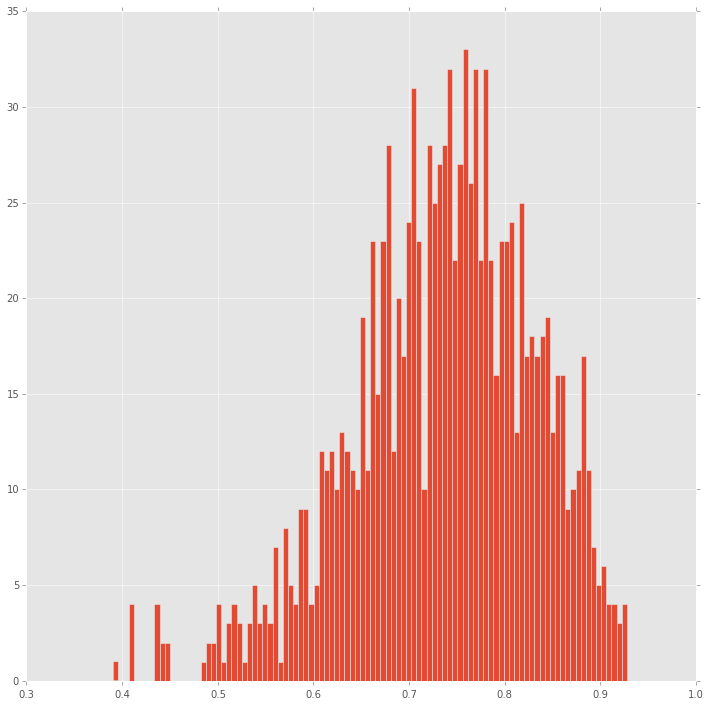

In [55]:
#plt.hist(resultsValues['preds'])
(resultsValues['preds']).hist(bins=100,figsize=(12,12))

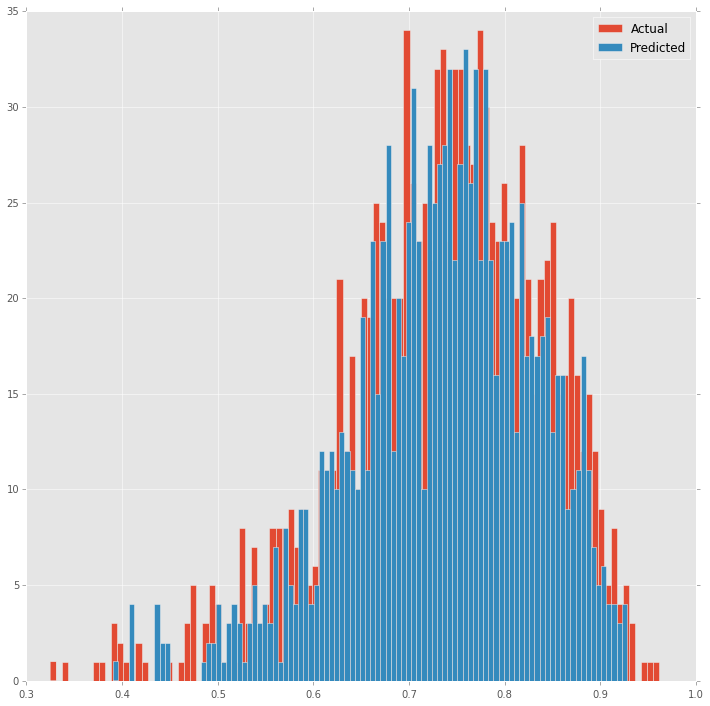

In [57]:
plt.figure(1)
plt.hist(label_testr,bins=100)
resultsValues['preds'].hist(bins=100,figsize=(12,12))
plt.legend(['Actual','Predicted'])
plt.show()

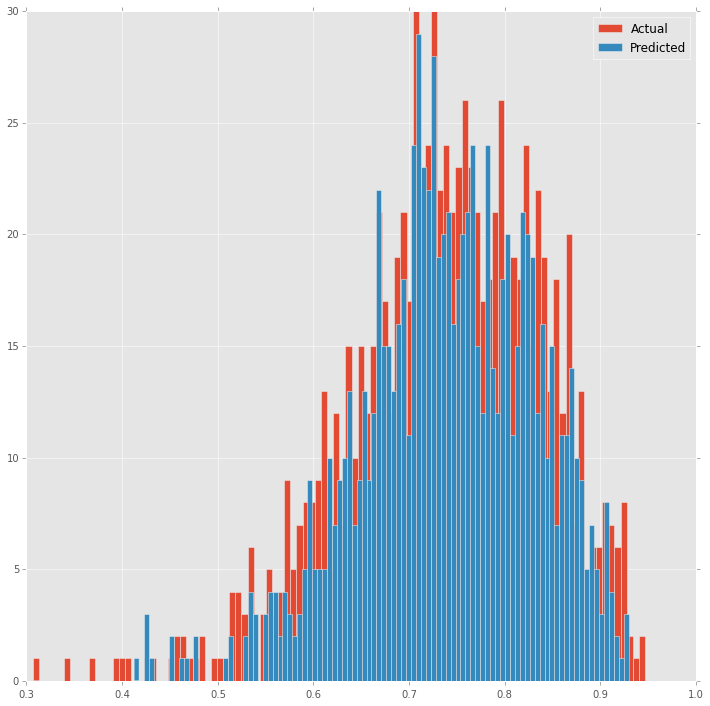

In [58]:
plt.figure(1)
plt.hist(label_validr,bins=100)
resultsValuesValid['preds'].hist(bins=100,figsize=(12,12))
plt.legend(['Actual','Predicted'])
plt.show()

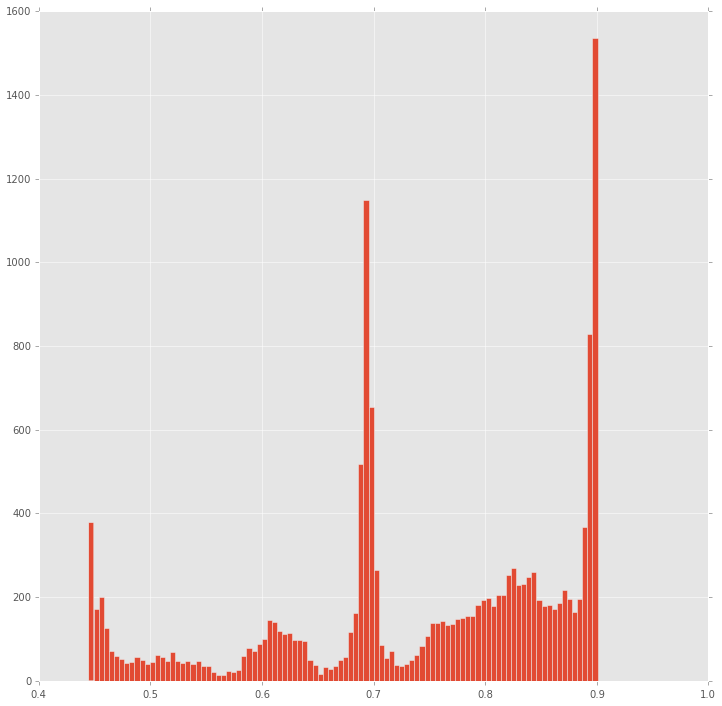

In [59]:
plt.figure(1)
resultsblock['pred_blck'].hist(bins=100,figsize=(12,12))
#plt.ylim(0,400)